# Prova 2 - NLP - 2025s1

INSTRUÇÕES: Resolva esta prova. Após, transcreva as partes dissertativas das respostas para o Blackboard (CTRL-C / CTRL-V) nos espaços indicados. Por fim, anexe seu notebook como material complementar da Questão 2.

## Rubrica geral da prova

Níveis de aprendizado

* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

## Problema

É relativamente comum usarmos embeddings gerados pelo BERT para classificar frases. Em geral, o código para gerar embeddings com BERT se parece com:

    from transformers import BertTokenizer, BertModel
    from tqdm import tqdm
    import numpy as np
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    def get_embeddings(text, model, tokenizer):
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[0, 0, :]
        return cls_embedding

    embeddings = []
    for i in tqdm(range(len(X))):
        e = get_embeddings(X.iloc[i], model, tokenizer)
        embeddings.append(e.detach().numpy())
    embeddings = np.array(embeddings)
    np.save('bert_embeddings.npy', embeddings)

De acordo com o [artigo do BERT](https://arxiv.org/abs/1810.04805), os embeddings foram treinados, usando um token por palavra, em diversos textos em inglês:

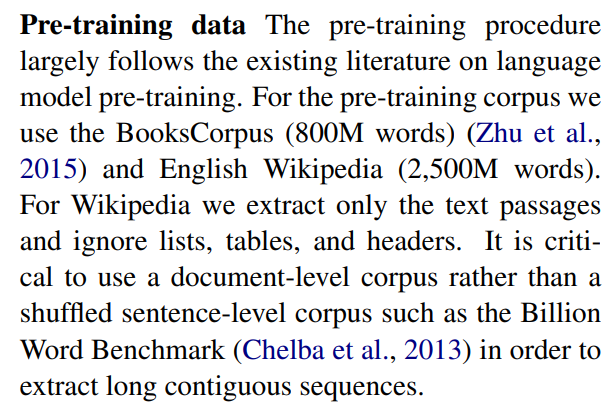

Porém, em lugares que não temos a língua inglesa como língua padrão, gostaríamos de realizar tarefas de classificação em línguas nativas.

Neste trabalho, vamos trabalhar com a classificação de mensagens no twitter sobre o Ibovespa. A ideia de fazer essa classificação é que o Twitter poderia ser uma representação do sentimento geral do mercado (*bullish* ou *bearish* markets). O dataset para isso é o seguinte:

In [29]:
import kagglehub
from pathlib import Path
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("jvbeltra/sentiment-analysis-pt-br-stock-market-tweets")
path = Path(path)
df = pd.read_csv(path / "analise_sentimentos_ibovespa_twitter.csv")
df.head()

,post_id,text,created_at,finbertptbr_prediction,gpt_prediction,real_sentiment
0,1818246570069934451,"a partir desse cálculo, para cada empresa do i...",2024-07-30T08:25:38.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
1,1818251106570395982,ibovespa reage às entrelinhas do relatório de ...,2024-07-30T08:43:39.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
2,1818257465793765640,ibovespa em queda de olho na reunião do copom,2024-07-30T09:08:56.000000Z,NEGATIVE,NEGATIVE,NEGATIVE
3,1818262436144669087,esquenta dos mercados \nbom dia!\no ibovespa a...,2024-07-30T09:28:41.000000Z,POSITIVE,NEUTRAL,NEUTRAL
4,1818262819063660642,ibovespa futuro cai na expectativa pelo 1º dia...,2024-07-30T09:30:12.000000Z,NEGATIVE,NEGATIVE,NEGATIVE


Como podemos ver, a tarefa é relacionar o conteúdo da coluna "text" ao rótulo colocado em "real_sentiment". Este dataset em especial já traz predições realizadas por outros modelos (finBertPt e GPT 3.5), que foram usadas em trabalhos anteriores. Ignore essas informações pois não vamos usá-las.

Para extrair embeddings de todos os textos do dataset, podemos usar o seguinte laço:

In [2]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def get_embeddings(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[0, 0, :]
    return cls_embedding

embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model, tokenizer)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_embeddings.npy', embeddings)

100%|██████████| 1290/1290 [00:39<00:00, 32.33it/s]


Porém, BERT foi treinado em inglês, e, portanto, talvez haja problemas com o vocabulário em português. Para evitar isso é possível usar a versão multilingual de BERT, que foi treinada em dumps da Wikipedia em várias línguas:

In [3]:
tokenizer_pt = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model_pt = BertModel.from_pretrained("bert-base-multilingual-uncased")
embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model_pt, tokenizer_pt)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_pt_embeddings.npy', embeddings)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

100%|██████████| 1290/1290 [00:41<00:00, 30.83it/s]


Por fim, temos sempre nossa hipótese nula: a de que um sistema com Bag of Words funciona bem o suficiente para nossa tarefa:

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['real_sentiment'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.19      0.30        53
     NEUTRAL       0.61      0.74      0.67        98
    POSITIVE       0.71      0.83      0.76       107

    accuracy                           0.67       258
   macro avg       0.70      0.59      0.58       258
weighted avg       0.68      0.67      0.63       258



## Perguntas

### Exercício 1

Por que faz sentido dizer que o BERT multilingue deveria ser uma alternativa melhor que o BERT original para esta tarefa de classificação? Articule sua argumentação tendo em vista a rubrica:


* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

A escolha do BERT multilingue (mBERT) sobre o BERT original para tarefas em português deveria estar enraizada em como os modelos são treinados e como codificam informações linguísticas. 

O BERT original, treinado apenas em inglês, opera em um espaço semântico otimizado para padrões morfossintáticos e distribuição de palavras específicos da língua inglesa. Quando aplicado a textos em português, deveria surgir um **descompasso estrutural**, ou seja, as palavras em português são forçadas a um espaço vetorial (embeddings) que nunca viu exemplos suficientes dessas unidades linguísticas durante o treinamento. Matematicamente, isso implica que a função de embedding $( f(x, \theta_{\text{en}}) )$, ajustada para inglês, mapeia termos em português para regiões do espaço $( \mathbb{R}^d )$ (onde $R$ é o espaço vetorial e $d$ a dimensão do embedding) que não refletem suas relações semânticas reais. Isso resulta em embeddings de palavras em português que são **pobres em informação**, levando a uma representação vetorial com baixa densidade semântica, aumentando a distância entre vetores de palavras semanticamente próximas (ex: "feliz" e "alegre").

O mBERT, por outro lado, foi treinado para minimizar uma função de perda multilingue, onde o objetivo é otimizar simultaneamente múltiplas línguas, incluindo o português. Isso significa que, durante o treinamento, o modelo aprendeu a **alinhar distribuições de probabilidade** entre línguas. Por exemplo, a probabilidade $( P(\text{"bom"} | \text{contexto\_pt}))$ é ajustada diretamente, enquanto no BERT original, o mesmo termo seria tratado como OOV (*out-of-vocabulary*), resultando onde o mBERT constrói um espaço de embeddings onde palavras como "bom" (português) e "good" (inglês) ocupam regiões vizinhas, preservando relações semânticas mesmo entre línguas.

Além disso, de acordo com o paper, a arquitetura do mBERT **aprende invariâncias cross-linguais**, onde camada do Transformer ajusta pesos que capturam padrões (ex: concordância entre sujeito e verbo) e específicos por língua. Aplicando no nosso caso, o português, isso permite que o modelo reconheça, por exemplo, que a flexão verbal em "cantávamos" carrega informações temporais e de número, mesmo que essas estruturas não existam no inglês. 


Resumindo, a vantagem do mBERT deveria surgir de três pontos principais:  
1) **Exposição direta ao português durante o treinamento**, onde o modelo aprende a codificar relações semânticas e morfológicas específicas da língua;
2) **Alinhamento geométrico no espaço vetorial**, onde palavras em português são mapeadas para regiões densas e semanticamente coerentes, preservando relações entre línguas;
3) **Generalização de padrões linguísticos** universais, onde o modelo aprende a reconhecer estruturas comuns entre línguas, como concordâncias.

Isso se traduz em embeddings mais precisos e, consequentemente, em maior acurácia para tarefas como classificação de sentimentos, onde nuances contextuais e culturais do português são críticas.

### Exercício 2

Compare o classificador que usa BERT original com aquele que usa BERT multilingual. De acordo com os resultados de classificação, e com a visualização de embeddings usando TSNE (se quiser, use também PCA), discuta se os argumentos discutidos no exercício 1 se refletiram, de fato, em um aumento de desempenho.

* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

In [41]:
embeddings = np.load('bert_embeddings.npy')
embeddings_pt = np.load('bert_pt_embeddings.npy')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['real_sentiment'], test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.35      0.32      0.34        53
     NEUTRAL       0.61      0.60      0.61        98
    POSITIVE       0.69      0.73      0.71       107

    accuracy                           0.60       258
   macro avg       0.55      0.55      0.55       258
weighted avg       0.59      0.60      0.59       258



In [43]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_pt, df['real_sentiment'], test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.42      0.21      0.28        53
     NEUTRAL       0.59      0.61      0.60        98
    POSITIVE       0.65      0.79      0.71       107

    accuracy                           0.60       258
   macro avg       0.55      0.53      0.53       258
weighted avg       0.58      0.60      0.58       258



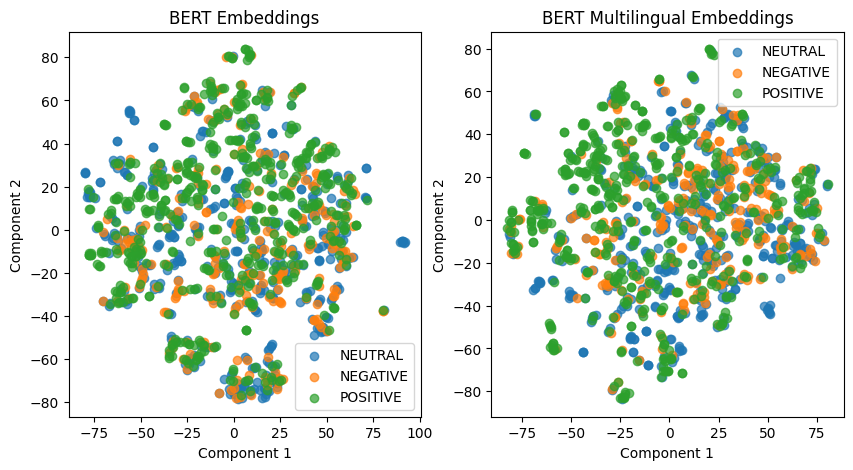

In [44]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA on the embeddings
embeddings = np.load('bert_embeddings.npy')
embeddings_pt = np.load('bert_pt_embeddings.npy')
pca = TSNE(n_components=2, perplexity=5)
embeddings_pca = pca.fit_transform(embeddings)
pca_pt = TSNE(n_components=2, perplexity=5)
embeddings_pca_pt = pca_pt.fit_transform(embeddings_pt)

# Create a scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_pca[indices, 0], embeddings_pca[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()


plt.subplot(1, 2, 2)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_pca_pt[indices, 0], embeddings_pca_pt[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Multilingual Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


## Resposta 2:

### Visualização dos embeddings:

Analisando o plot (TSNE sobre os embeddings), podemos ver que os embeddings do mBert (BERT Multilingual Embeddings) em relação ao componente 1, ficaram sido mais "compactados", variando de -75 até ~80, enquanto os embeddings do BERT original variam de -75 até ~100. Mas, podemos ver que isso não se reflete em uma separação clara entre as classes, apenas em uma maior compactação dos embeddings.

A visualização dos embeddings usando TSNE mostra que, mesmo com o mBERT, as classes (NEUTRAL, NEGATIVE, POSITIVE) não estão claramente separadas. Isso sugere que, apesar de uma possível compactação melhor dos embeddings sobre o componente 1, a tarefa de classificação ainda enfrenta desafios significativos para diferenciar entre as classes.

Com base nisso, podemos dizer que o resultado usando o mBERT não foi o que esperávamos e defendemos no exercício 1, onde esperávamos uma previsão melhor dado que estaríamos usando um modelo de embeddings da mesma língua que o dataset.

### Acurácia:

- **bert_embeddings.npy:** 60%
- **bert_pt_embeddings.npy:** 60%

A acurácia de 60% para ambos os modelos sugere que, apesar das diferenças teóricas propostas (ex.1) entre o BERT original e o mBERT, a tarefa de classificação de sentimentos no Twitter não se beneficiou dessa mudança de modelos.

-------

### Conclusão:

A partir dos resultados supracitados, podemos dizer que os argumentos discutidos no exercício 1 não se refletiram, e não resultou em um aumento de desempenho, tanto na acurácia quanto na visualização dos embeddings (TSNE). 

**Refletindo sobre os resultados:**

Isso pode ser devido a vários fatores:
1. **Ruído nos dados:** O Twitter é uma plataforma onde as pessoas escrevem de maneira livre e, muitas vezes, informal. Então, emojis, gírias e abreviações são artifícios que as pessoas acabam utilizando e, que podem dificultar a tarefa de classificação, independentemente do modelo utilizado. Exemplos:
    - "por enquanto vai dando bingo duplo hein kkkk no win e no ibov kkk"
    - "ibov / tsla é top, cybertruck é outro conceito"
    - "esse é o meu ibov!!!!!!"

    **Obs.:** Todos esses exemplos foram retirados do dataset.

    Isso pode acontecer, pois mesmo que o mBERT tenha sido treinado em português, ele pode não ter visto exemplos semelhantes durante o treinamento. Isso pode levar a uma representação inadequada de palavras e frases, resultando em embeddings que não capturam bem o significado semântico, principalmente quando se trata de ironias, gírias, sarcasmos, que são comuns no Twitter.

    E, esse pode ser uma limitação do mBERT, pois ele foi treinado em um conjunto de dados que pode não refletir a informalidade e o estilo de escrita do Twitter.

2. **Tamanho do dataset:** O tamanho do dataset pode não ser suficiente para capturar a diversidade e complexidade da linguagem usada no Twitter.